In [22]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [23]:
# Function to fetch historical crypto price data from CoinGecko API.
def fetch_crypto_data(crypto_id, vs_currency='usd', days='365'):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
    params = {'vs_currency': vs_currency, 'days': days, 'interval': 'daily'}
    response = requests.get(url, params=params)
    data = response.json()
    return data['prices']

# Fetch Bitcoin price data for the past 365 days.
crypto_id = 'bitcoin'
data = fetch_crypto_data(crypto_id)


In [24]:
# Convert the fetched data into a DataFrame.
df = pd.DataFrame(data, columns=['timestamp', 'price'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime
df.set_index('date', inplace=True)  # Set the date as index
df.drop(columns=['timestamp'], inplace=True)  # Drop unnecessary column

# Print the first few rows of the DataFrame
print(df.head())


                   price
date                    
2024-01-29  42026.578562
2024-01-30  43267.609276
2024-01-31  42892.034530
2024-02-01  42583.263547
2024-02-02  43069.043421


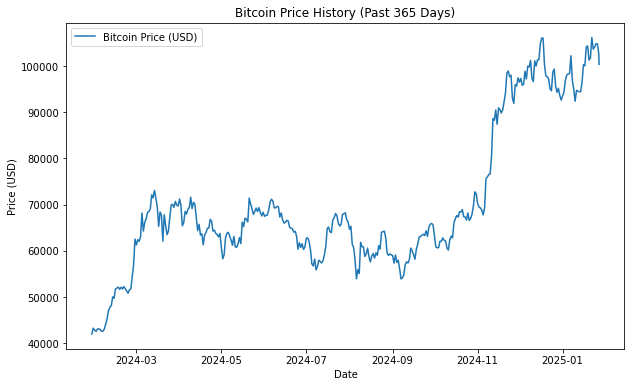

In [25]:
# Plot the closing price of Bitcoin over time.
plt.figure(figsize=(10,6))
plt.plot(df.index, df['price'], label='Bitcoin Price (USD)')
plt.title('Bitcoin Price History (Past 365 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [26]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare the data for LSTM (using previous 60 days to predict the next day's price)
X = []
y = []
look_back = 60

for i in range(look_back, len(df)):
    X.append(df_scaled[i-look_back:i, 0])  # Data from the last 60 days
    y.append(df_scaled[i, 0])  # The next day's price

X = np.array(X)
y = np.array(y)

# Reshaping X for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shapes of the datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (244, 60, 1)
Shape of X_test: (62, 60, 1)


In [27]:
# Build an LSTM model
model = Sequential()

# Add the first LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add the second LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
8/8 [==============================] - 5s 153ms/step - loss: 0.0450 - val_loss: 0.0165
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0119 - val_loss: 0.0679
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 4/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 5/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0051 - val_loss: 0.0161
Epoch 6/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 7/10
8/8 [==============================] - 0s 45ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 8/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 9/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 10/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0039 - val_loss: 0.0056


In [29]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values for comparison
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print the first few predicted and actual values
print("Predicted Prices:", y_pred_rescaled[:5])
print("Actual Prices:", y_test_rescaled[:5])


2/2 [==============================] - 1s 18ms/step
Predicted Prices: [[98203.95]
 [98627.64]
 [98936.71]
 [99264.23]
 [99527.05]]
Actual Prices: [[95981.18057211]
 [95661.59595818]
 [97453.2473451 ]
 [96513.14234698]
 [97311.70719084]]


In [30]:
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Absolute Error: {mae:.2f} USD')


Mean Absolute Error: 3834.77 USD


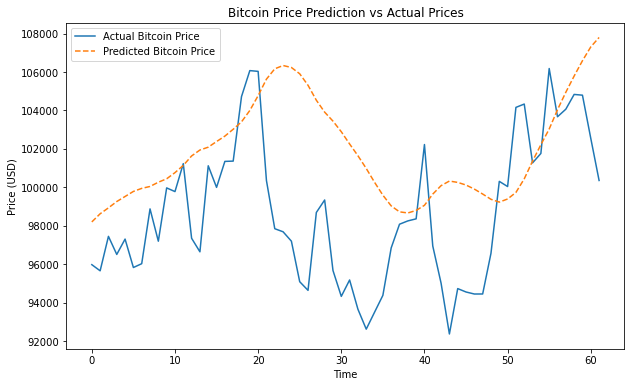

In [31]:
# Plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual Bitcoin Price')
plt.plot(y_pred_rescaled, label='Predicted Bitcoin Price', linestyle='--')
plt.title('Bitcoin Price Prediction vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [32]:
# Save the trained model
model.save('bitcoin_price_predictor.h5')
